## k - parameter estimation

In [32]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

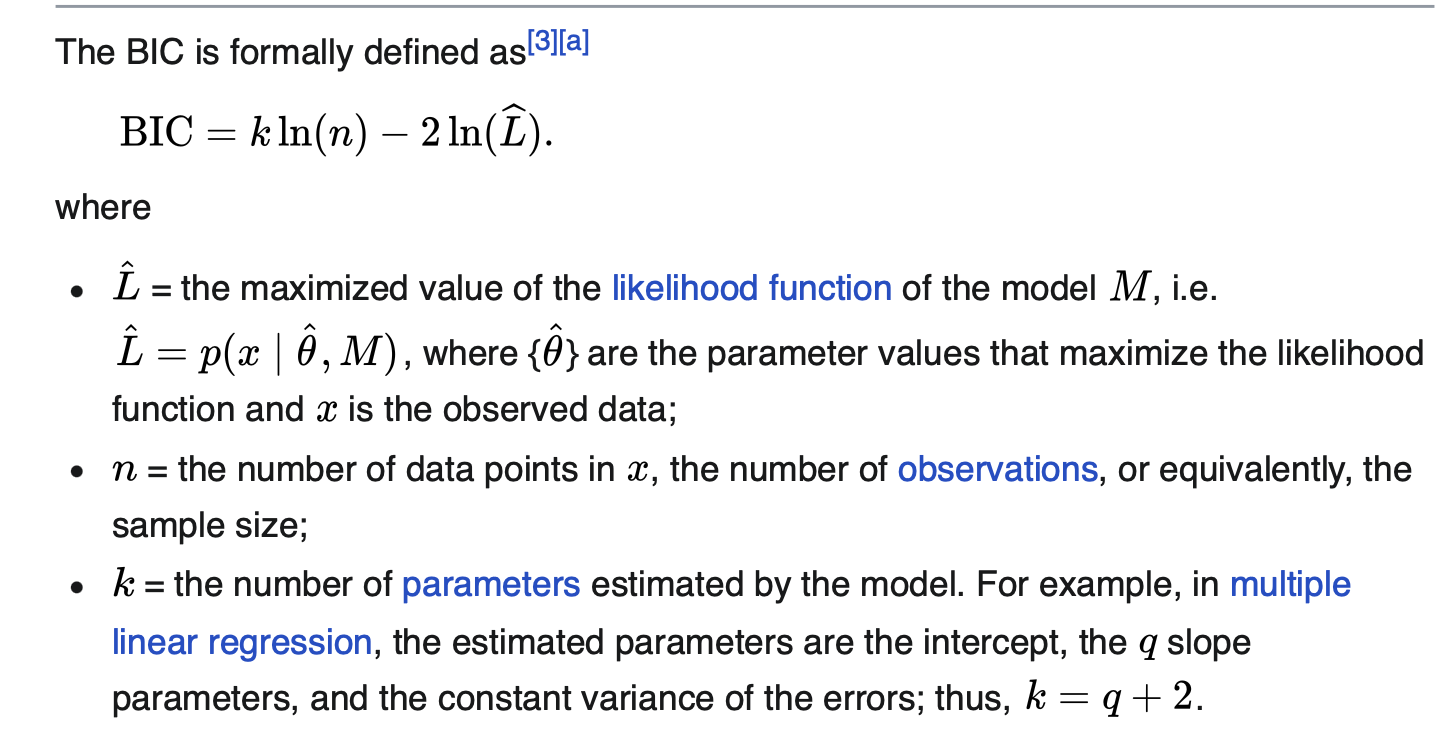

In [38]:
def perform_matrix_analysis_bic_poisson(
    M_path, decomposed_matrices_folder, iterations, k_values, print_heatmaps=False, verbose=True, lambda_=0.01
):
    """
    Analyze matrix decomposition by computing BIC, AIC, and log-likelihood for different k-values (Poisson distribution).

    Parameters:
    - M_path (str): Path to the original matrix file.
    - decomposed_matrices_folder (str): Path to folder with decomposed matrices (W and H).
    - iterations (int): Number of repetitions for each k-value.
    - k_values (range): Range of k-values to analyze.
    - print_heatmaps (bool): Whether to print heatmaps.
    - verbose (bool): Print detailed output.
    - lambda_ (float): Regularization parameter for underfitting penalties.

    Returns:
    - dict: Results for each k-value.
    """

    def compute_log_likelihood_poisson(M, reconstructed_M):
        """Log-likelihood for Poisson distribution."""
        reconstructed_M = np.clip(reconstructed_M, 1e-10, None)  # Avoid log(0)
        return np.sum(M * np.log(reconstructed_M) - reconstructed_M)

    def compute_bic(M, W, H):
        """Compute BIC, AIC, and log-likelihood for given W and H."""
        reconstructed_M = np.dot(W, H)
        log_likelihood = compute_log_likelihood_poisson(M, reconstructed_M)
        m, n, r = *M.shape, W.shape[1]
        num_parameters = m * r + r * n
        bic = -2 * log_likelihood + num_parameters * np.log(m * n)
        aic = -2 * log_likelihood + 2 * num_parameters
        return bic, aic, log_likelihood

    # Load and normalize the original matrix
    M = pd.read_csv(M_path).iloc[:, 1:].values.astype(float)
    M /= M.sum(axis=0, keepdims=True)

    results = {}
    for k in k_values:
        bics, log_liks, aics = [], [], []
        for rep in range(1, iterations + 1):
            W_path, H_path = f"{decomposed_matrices_folder}/D_k{k}_rep{rep}.csv", f"{decomposed_matrices_folder}/lambda_k{k}_rep{rep}.csv"
            if not os.path.exists(W_path) or not os.path.exists(H_path):
                continue
            W, H = pd.read_csv(W_path, header=None).values, pd.read_csv(H_path, header=None).values
            bic, aic, log_likelihood = compute_bic(M, W, H)
            bics.append(bic), log_liks.append(log_likelihood), aics.append(aic)

        if log_liks:
            # Remove outliers using IQR
            q1, q3 = np.percentile(log_liks, [25, 75])
            iqr = q3 - q1
            bounds = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
            valid_idx = [i for i, log_lik in enumerate(log_liks) if bounds[0] <= log_lik <= bounds[1]]
            bics, log_liks, aics = [bics[i] for i in valid_idx], [log_liks[i] for i in valid_idx], [aics[i] for i in valid_idx]

            if bics:
                results[k] = {
                    "mean_bic": np.mean(bics), "min_bic": np.min(bics),
                    "mean_aic": np.mean(aics), "min_aic": np.min(aics),
                    "mean_log": np.mean(log_liks), "min_log": np.min(log_liks)
                }

    # Plot mean log-likelihood, BIC, and AIC vs k
    plt.figure(figsize=(10, 6))
    mean_logs = [results[k]["mean_log"] for k in k_values if k in results]
    mean_bics = [results[k]["mean_bic"] for k in k_values if k in results]
    mean_aics = [results[k]["mean_aic"] for k in k_values if k in results]

    plt.plot(k_values, mean_logs, marker='o', label='Mean Log-Likelihood', color='b')
    plt.title(f"Model Performance vs k (Poisson), lambda = {lambda_}")
    plt.xlabel("k")
    plt.ylabel("Scores")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

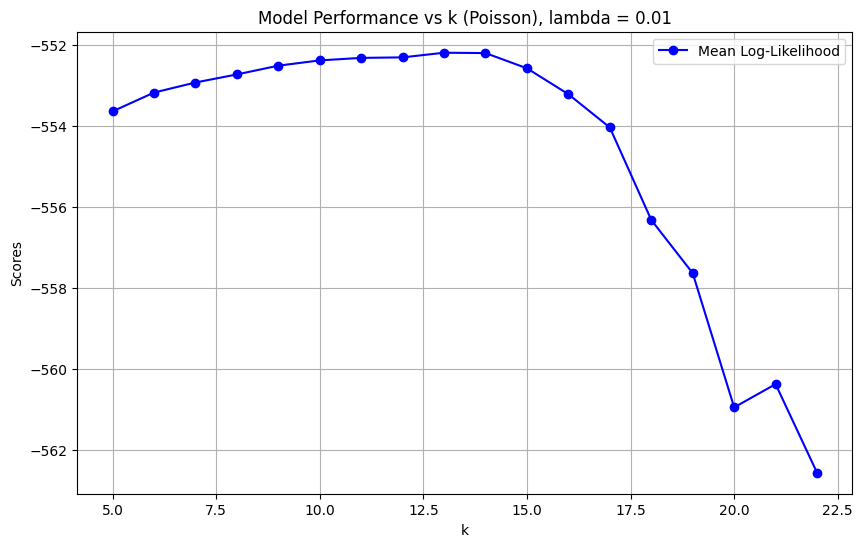

In [34]:
M_path = 'simulated_data/s_15_n_0.06_GRCh37_17b_86_98_39_22a_43_17a_13_54_33_21_59_60_87_37.csv'
decomposed_matrices_folder = 'decomposed_matrices_s_15_n_0.06'
iterations = 100
k_values = range(6, 21)

results = perform_matrix_analysis_bic_poisson(
    M_path=M_path,
    decomposed_matrices_folder=decomposed_matrices_folder,
    iterations=100,
    k_values=range(5, 23),
    verbose=False,
)

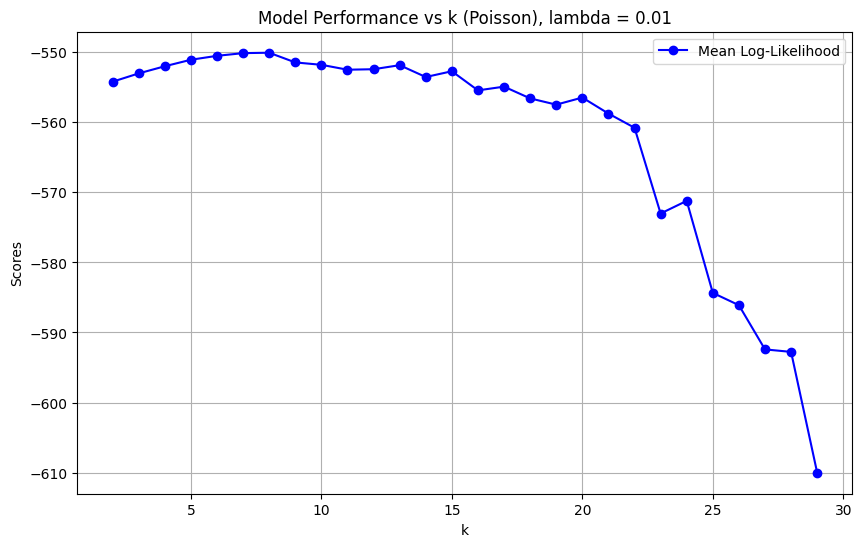

In [36]:
M_path = 'simulated_data/s_8_n_0.04_GRCh37_17b_86_98_39_22a_43_17a_13.csv'
decomposed_matrices_folder = 'decomposed_matrices_s_8_n_0.04'
iterations = 100
k_values = range(6, 21)
results = perform_matrix_analysis_bic_poisson(
    M_path=M_path,
    decomposed_matrices_folder=decomposed_matrices_folder,
    iterations=80,
    k_values=range(2, 30),
    verbose=False,
)

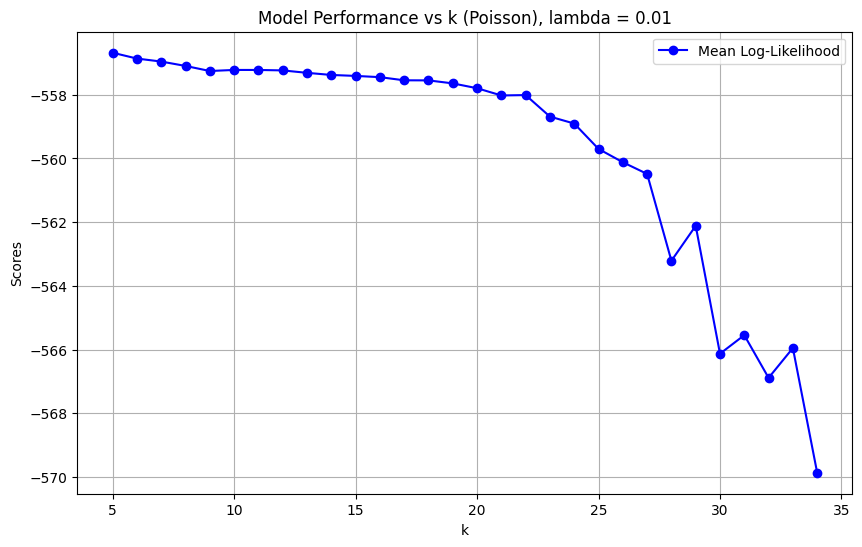

In [37]:


results = perform_matrix_analysis_bic_poisson(
    M_path='simulated_data/s_25_n_0.04_GRCh37_17b_86_98_39_22a_43_17a_13_54_33_21_59_60_87_37_96_28_55_99_26_3_1_12_93_22b.csv',
    decomposed_matrices_folder='decomposed_matrices_s_25_n_0.06',
    iterations=100,
    k_values=range(5, 35),
    verbose=False
)